# Pipeline TE

In [2]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *
from arcolanche.transfer_entropy_func import *

import statsmodels.api as sm

from utils_CB import get_coarsegrained, plot_cells, get_ids_from_centroid, plot_avalanches

from math import factorial

from shapely.geometry import LineString
from keplergl import KeplerGl


In [ ]:
# ====================================================================================== #
# Module for pipelining the analysis of causal graphs with higher network degrees. Sandbox.
# Author: Clemens Baldzuhn
# ====================================================================================== #

# Data, subset

In [3]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)

dt, dx, gridix = mesoscale

#data
load_pickle(f"avalanches/{conflict_type}/gridix_{gridix}/te/conflict_ev_{str(dt)}_{str(dx)}.p")
count_ts = get_coarsegrained(conflict_type, scale = mesoscale, binary=True)
polygons = load_voronoi(dx, gridix) #dx=57/b=528km, gridix=3

In [4]:
conflict_ev

,event_date,longitude,latitude,geometry,t,day,x,fatalities
236742,1997-01-01,36.681,17.152,POINT (36.68100 17.15200),0,0,4868,0
236743,1997-01-01,36.410,15.430,POINT (36.41000 15.43000),0,0,3404,0
32482,1997-01-01,18.555,4.361,POINT (18.55500 4.36100),0,0,6325,2
158850,1997-01-01,29.004,-2.393,POINT (29.00400 -2.39300),0,0,9335,1
265178,1997-01-01,32.306,2.767,POINT (32.30600 2.76700),0,0,7408,4
...,...,...,...,...,...,...,...,...
234461,2019-12-31,33.790,8.382,POINT (33.79000 8.38200),262,8399,5135,4
57029,2019-12-31,29.446,-1.187,POINT (29.44600 -1.18700),262,8399,8109,0
57030,2019-12-31,29.941,0.629,POINT (29.94100 0.62900),262,8399,7569,1
196379,2019-12-31,45.334,2.041,POINT (45.33400 2.04100),262,8399,11904,0


Subset of dataset is used: Construct.py subsets neighborhood of degree three around central node 7311. Quite messy way to do it but yeah.

Cells in subset: 35
tuples in subset of size 3: 1190.0
dt: 32, dx: 453 gridix: 3


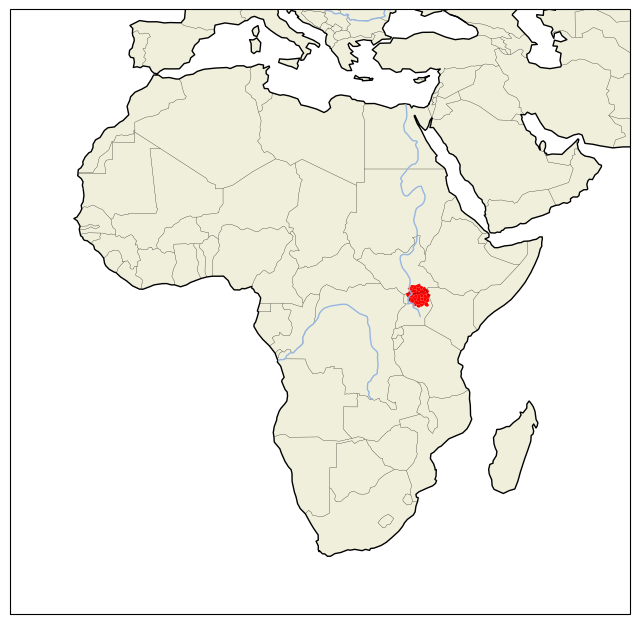

In [ ]:
size = 3
degree = 2
centroid = 7311 #counts: 218 
cell_ids = get_ids_from_centroid(polygons, size= size, centroid = 7311)
print("Cells in subset:", len(cell_ids))


def binomial(n, k):
#number of unique k sets in n
    return (factorial(n)/(factorial(k)*factorial(n-k)))

print(f"tuples in subset of size {size}:", binomial(len(cell_ids), 2)*2)

#Plot subset (used in pipeline)
plot_cells(cell_ids, mesoscale, "battles", verbose=False)

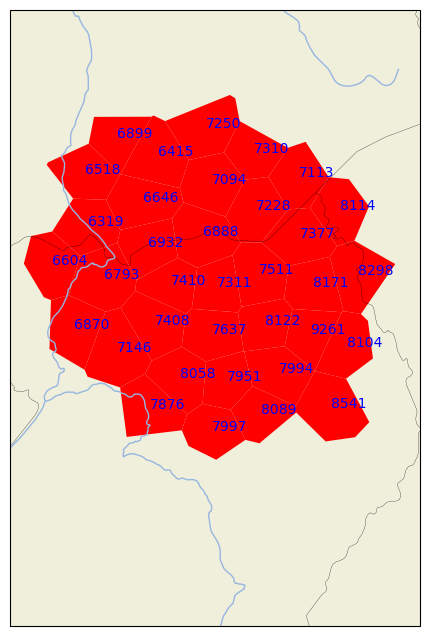

In [ ]:
# Zoom in
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Specify polygon and event here
for i, x in enumerate(cell_ids):
    poly = polygons.loc[[x]]
    poly.plot(ax=ax, color="red")
    
    # Get the centroid of the polygon
    centroid = poly.geometry.centroid.iloc[0]
    # Place the index of the polygon as text on the map
    ax.text(centroid.x, centroid.y, str(x), color='blue', transform=ccrs.Geodetic())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAND)   
ax.add_feature(cfeature.RIVERS)

# Zoom in on Kenya, South Sudan, and Uganda

ax.set_extent([31, 35, 0, 6], crs=ccrs.PlateCarree())

plt.show()

# Compare avalanches

### Whole graph, increasing size

In [ ]:
dt = 64
dx = 320
degree = 5

def open_avalanche(conflict_type, gridix, dt, dx, degree):
    path = f"Results/avalanches/{conflict_type}/gridix_{gridix}/d{degree}_ava_{str(dt)}_{str(dx)}.p"
    
    with open(path, 'rb') as file:
        data = pickle.load(file)
    return data


avas = [open_avalanche(conflict_type, gridix, dt, dx, degree=d) for d in range(1, degree+1)]
sets = [set(map(tuple, ava['ava_event'])) for ava in avas]


In [ ]:
# Calculate the size of each set
sizes = [len(s) for s in sets]

# Calculate pairwise intersections
intersections = [[len(sets[i].intersection(sets[j])) for j in range(len(sets))] for i in range(len(sets))]

# Calculate pairwise Jaccard indices
jaccard_indices = [
    [
        intersections[i][j] / len(sets[i].union(sets[j])) if i != j else 1.0
        for j in range(len(sets))
    ]
    for i in range(len(sets))
]

# Initialize the data for the table
data = {
    "Set": [f"Set {i+1}" for i in range(len(sets))],
    "Size": sizes
}

# Add intersection columns
for i in range(len(sets)):
    data[f"Intersect with Set {i+1}"] = intersections[i]

# Add Jaccard index columns
for i in range(len(sets)):
    data[f"Jaccard with Set {i+1}"] = jaccard_indices[i]

# Create a DataFrame
df = pd.DataFrame(data)
df

,Set,Size,Intersect with Set 1,Intersect with Set 2,Intersect with Set 3,Intersect with Set 4,Intersect with Set 5,Jaccard with Set 1,Jaccard with Set 2,Jaccard with Set 3,Jaccard with Set 4,Jaccard with Set 5
0,Set 1,7998,7998,4490,3212,2514,2015,1.000000,0.512265,0.374315,0.299001,0.242596
1,Set 2,5257,4490,5257,3244,2460,1989,0.512265,1.000000,0.558540,0.429995,0.355750
2,Set 3,3795,3212,3244,3795,2417,2001,0.374315,0.558540,1.000000,0.561832,0.486034
3,Set 4,2924,2514,2460,2417,2924,1986,0.299001,0.429995,0.561832,1.000000,0.609016
4,Set 5,2323,2015,1989,2001,1986,2323,0.242596,0.355750,0.486034,0.609016,1.000000


### Individual avalanches

In [ ]:
#avas[0]['ava_event'][9]
len(avas[0]['ava_event'])

7998

In [ ]:
#avas[1]['ava_event'][9]
len(avas[1]['ava_event'])

5257

In [ ]:
for i in zip(avas[0]['ava_event'], avas[1]['ava_event']):
    print(i)

([6, 9, 18, 20], [6, 9, 18, 20])
([12, 15], [12, 15])
([22], [22])
([37], [37])
([52118, 52133, 52148, 52157, 52156], [52118, 52133, 52148, 52157, 52156])
([52119], [52119, 52356, 52483, 52484, 52200, 52204, 52158, 52189, 52360, 52362, 52280, 52281, 52304, 52306, 52355, 52365, 52418, 51967, 51972, 51975, 51978, 52063, 52068, 52065, 52072, 52071, 52073, 52074, 52076, 52078, 52081, 52080, 52082, 52599, 52627, 52253, 52257, 52231, 52143, 52236, 52655, 52833, 52300, 52301, 52320, 52357, 52272, 51997, 52087, 51933, 53006, 53113, 53001, 53217, 52485, 52628, 52491, 52424, 52573, 52277, 52279, 52358, 53104, 53196, 52586, 52552, 52608, 52116, 52202, 22092, 52262, 52264, 53271, 53573, 52785, 52677, 52690, 52731, 52738, 52737, 52744, 52196, 52311, 52415, 52324, 51957, 51968, 52048, 52086, 53600, 53110, 53233, 53081, 53191, 53023, 52705, 52730, 52746, 22477, 53479, 53593, 52895, 52403, 53669, 53826, 53846, 53843, 53850, 53852, 53084, 51842, 51841, 53153, 52451, 52450, 52501, 52584, 52518, 52629, 5

(array([5.247e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

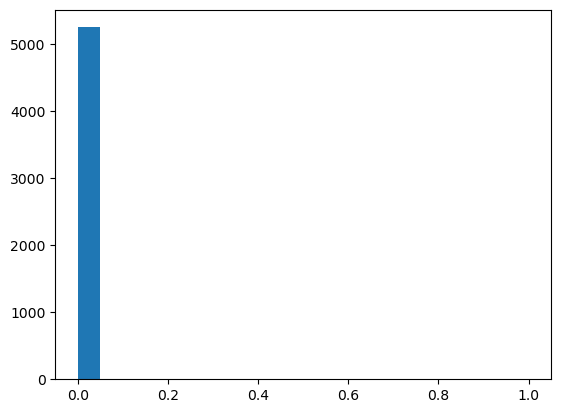

In [ ]:
# Compare individual avalanches

max_len = max([len(ava['ava_event']) for ava in avas])

def jaccard(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

jaccard = [jaccard(list1, list2) for list1, list2 in zip(avas[0]['ava_event'], avas[1]['ava_event'])]

#plot distribution of jaccard indices
plt.hist(jaccard, bins=20)


jaccard is basically zero from the 3rd avalanche onwards

# Plot avalanches

/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing ha

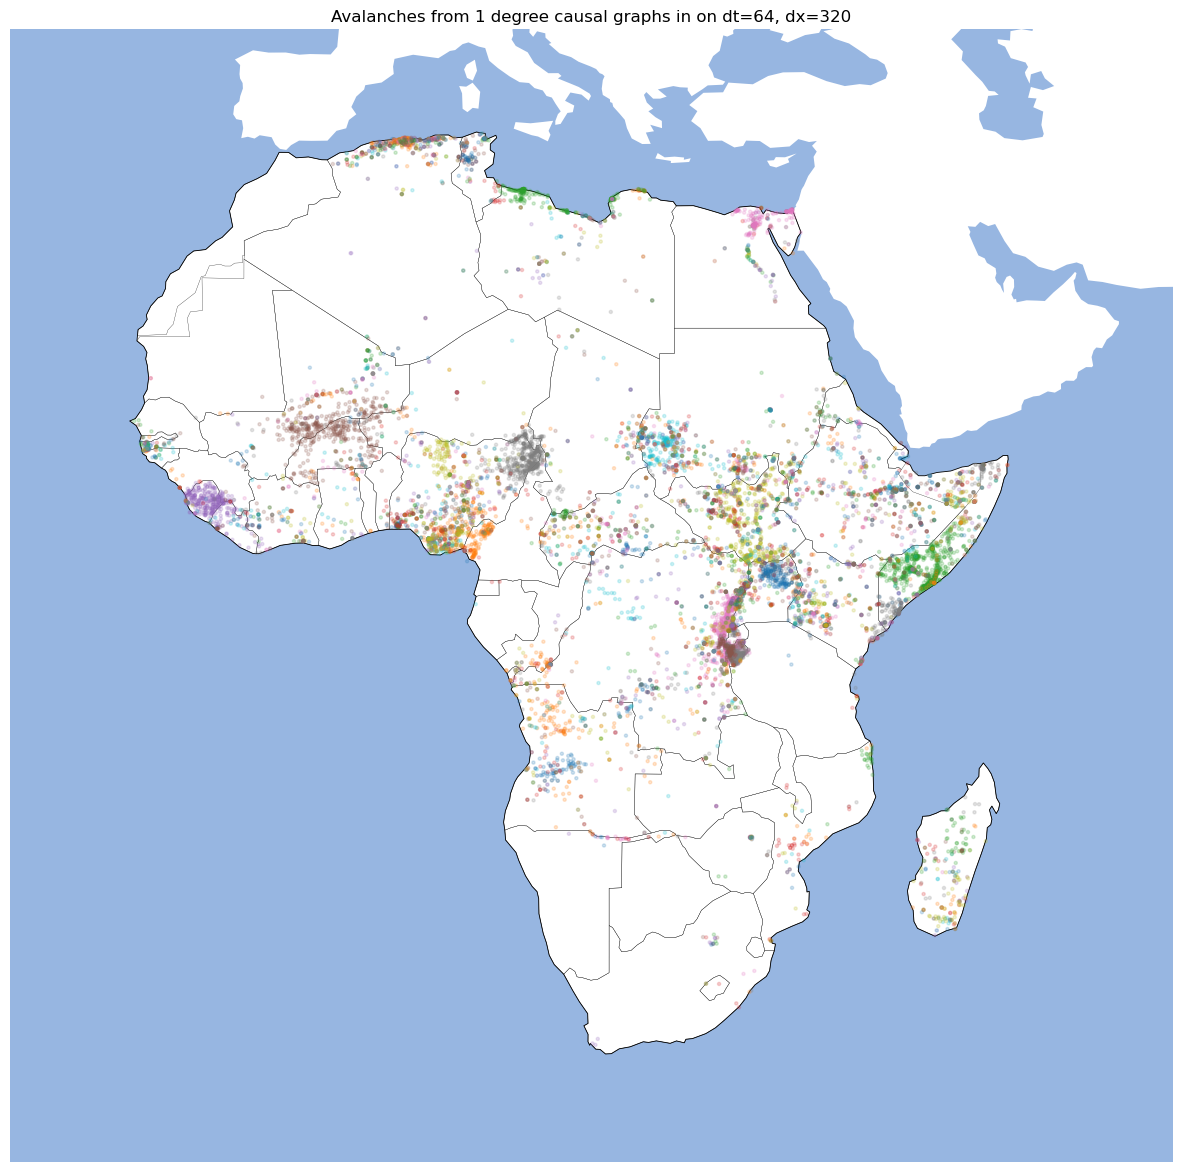

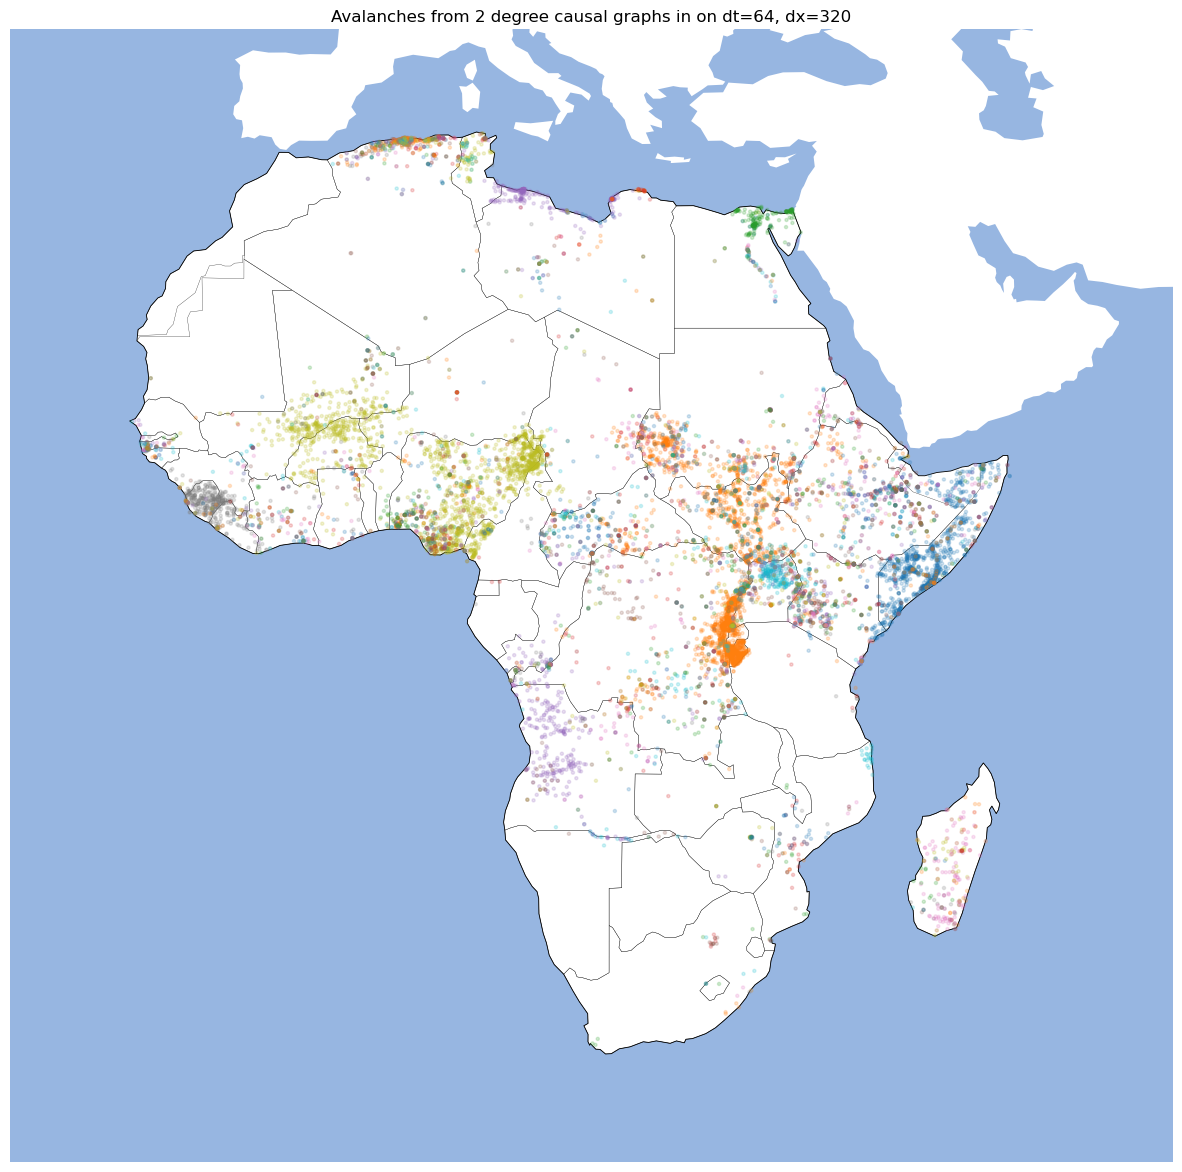

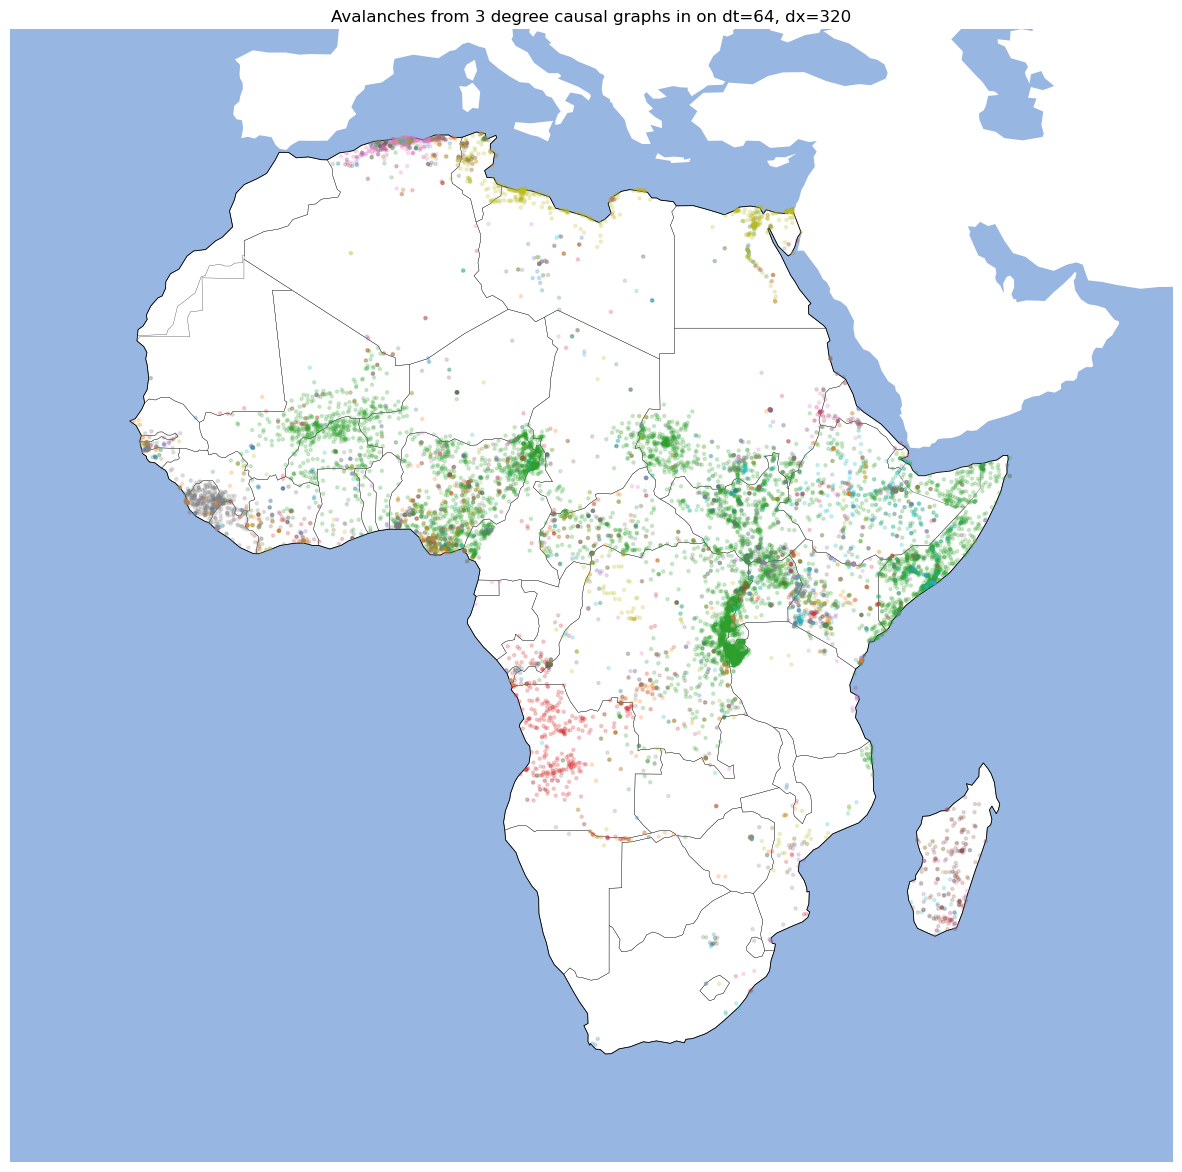

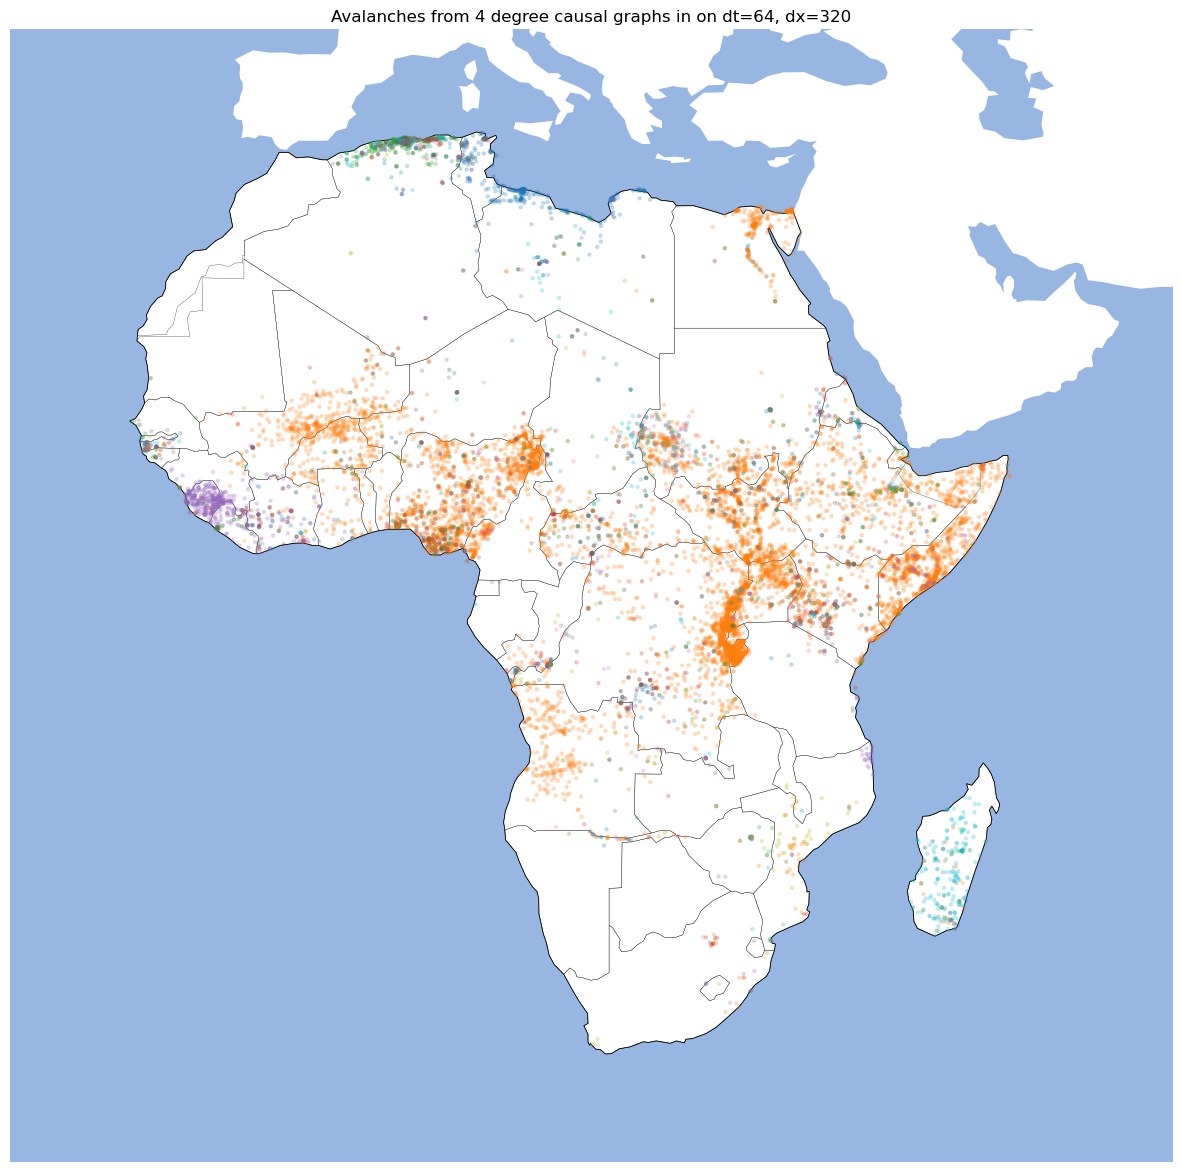

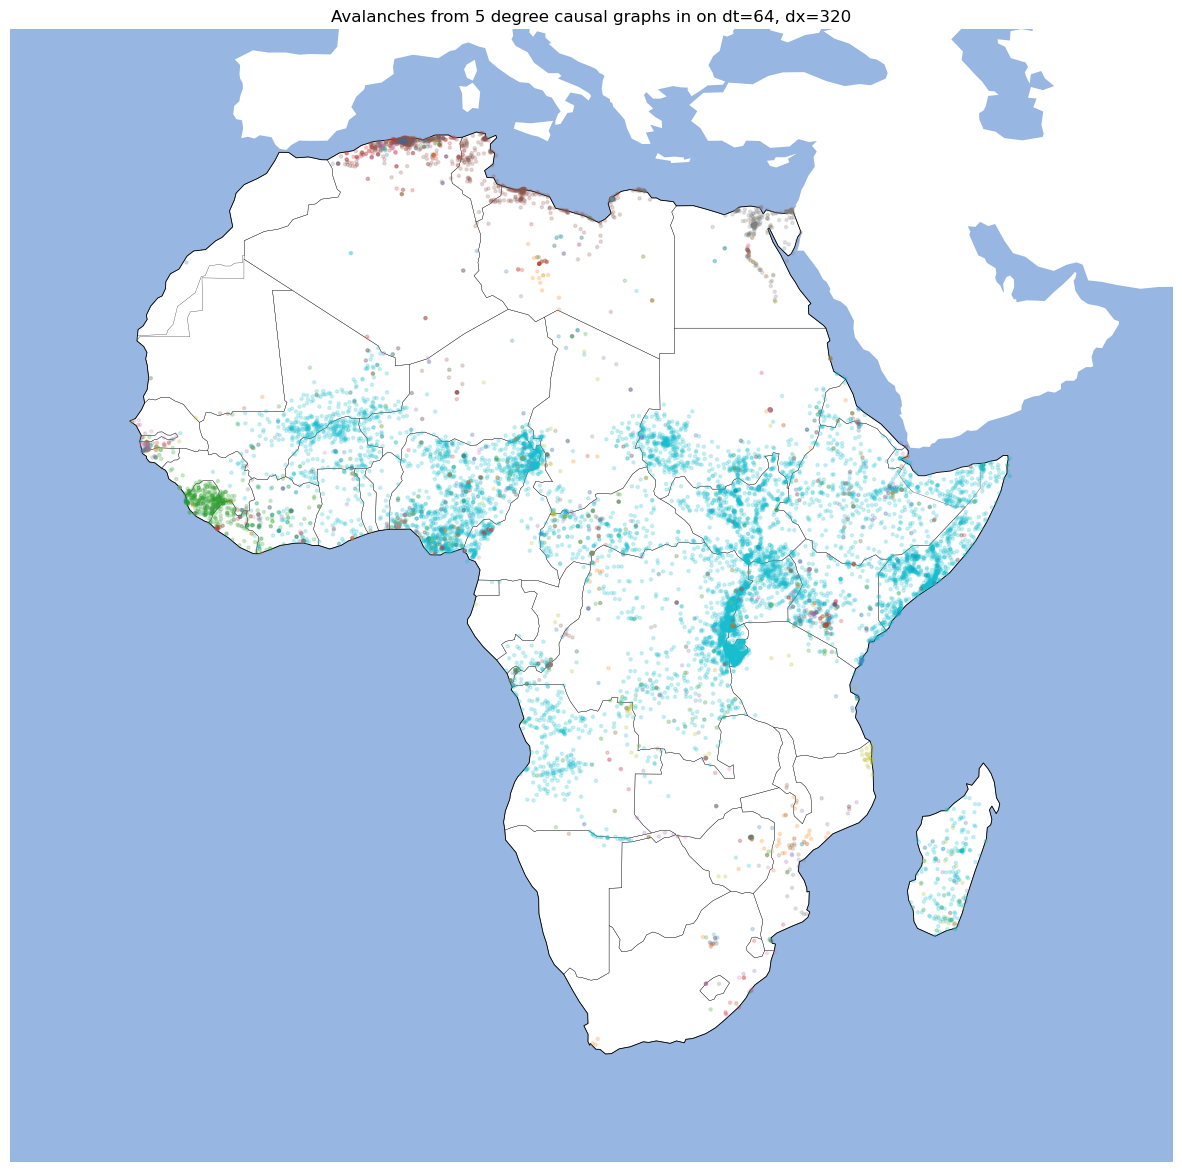

In [ ]:
from utils_CB import plot_avalanches

conflict_type = "battles"
gridix = 3
dt = 64
dx = 320




plot_avalanches(avalanche=avas[i], dt=dt, dx=dx, gridix = gridix, degree = i+1, conflict_type = "battles", save = False)


